<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/Hybrid%20RF-RNN%20for%205%20class%20classifications%20based%20on%20WSN-DS%20dataset_rev.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Hybrid RF-RNN for 5 class classifications based on WSN-DS dataset**

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
# Load dataset
dataset = pd.read_csv("dataset_WSN-DS.csv")
dataset.isnull().sum()

 id                 0
 Time               0
 Is_CH              0
 who CH             0
 Dist_To_CH         0
 ADV_S              0
 ADV_R              0
 JOIN_S             0
 JOIN_R             0
 SCH_S              0
 SCH_R              0
Rank                0
 DATA_S             0
 DATA_R             0
 Data_Sent_To_BS    0
 dist_CH_To_BS      0
 send_code          0
Expaned Energy      0
Class               0
dtype: int64

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374661 entries, 0 to 374660
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0    id               374661 non-null  int64  
 1    Time             374661 non-null  int64  
 2    Is_CH            374661 non-null  int64  
 3    who CH           374661 non-null  int64  
 4    Dist_To_CH       374661 non-null  float64
 5    ADV_S            374661 non-null  int64  
 6    ADV_R            374661 non-null  int64  
 7    JOIN_S           374661 non-null  int64  
 8    JOIN_R           374661 non-null  int64  
 9    SCH_S            374661 non-null  int64  
 10   SCH_R            374661 non-null  int64  
 11  Rank              374661 non-null  int64  
 12   DATA_S           374661 non-null  int64  
 13   DATA_R           374661 non-null  int64  
 14   Data_Sent_To_BS  374661 non-null  int64  
 15   dist_CH_To_BS    374661 non-null  float64
 16   send_code        37

In [22]:
dataset["Class"].unique()

array([0, 4, 3, 1, 2])

In [23]:
# Data preprocessing
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['Class'])
y = np_utils.to_categorical(y, num_classes=5)
X = dataset.drop(['Class'],axis=1)
X=X.values
print(X.shape)
print(y.shape)

(374661, 18)
(374661, 5)


In [24]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [25]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### **Hybrid combination of RF-RNN for 10 class classifications**

In [26]:
# Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

from keras.layers import SimpleRNN

# RNN model
model = Sequential()
model.add(SimpleRNN(64, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

history = model.fit(X_train_rnn, y_train, epochs=10, batch_size=64, validation_data=(X_test_rnn, y_test), verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4,549
Trainable params: 4,549
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21255/21255 [==============================] - 83s 4ms/step - loss: 0.2233 - accuracy: 0.8934 - val_loss: 0.1890 - val_accuracy: 0.9070
Epoch 2/10
21255/21255 [==============================] - 81s 4ms/step - loss: 0.2059 - accuracy: 0.8994 - val_loss: 0.1970 - val_accuracy: 0.9047
Epoch 3/10
21255/21255

In [27]:
# Combine models
y_pred_rnn = model.predict(X_test_rnn)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
y_pred_rnn = np_utils.to_categorical(y_pred_rnn, num_classes=5)

y_pred = y_pred_rnn * 0.5 + y_pred_rf * 0.5
y_pred = np.argmax(y_pred, axis=1)

# Evaluation metrics
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

from sklearn.metrics import accuracy_score
# Calculate accuracy
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print("Accuracy:", accuracy)

10628/10628 [==============================] - 17s 2ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     67745
           1       1.00      1.00      1.00     68144
           2       1.00      1.00      1.00     68282
           3       1.00      0.95      0.97     68009
           4       1.00      1.00      1.00     67886

    accuracy                           0.99    340066
   macro avg       0.99      0.99      0.99    340066
weighted avg       0.99      0.99      0.99    340066

[[67605    56     0    14    70]
 [   84 68050    10     0     0]
 [    0    19 68263     0     0]
 [ 3312   104    31 64562     0]
 [   13     7     0     0 67866]]
Accuracy: 0.9890609469926426


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  plt.figure(figsize=(6,5.5))
  ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='YlGnBu')
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-RNN Model


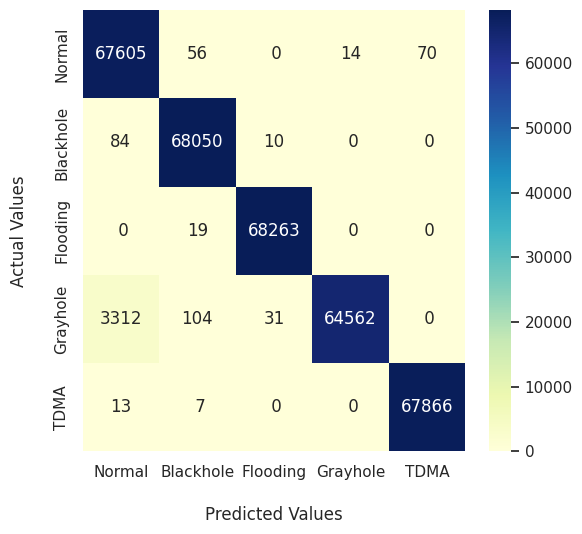

In [29]:
print("Confusion Matrix of Hybrid RF-RNN Model") 
conf_mat(np.argmax(y_test, axis=1), y_pred)

In [30]:
report = classification_report(np.argmax(y_test, axis=1), y_pred, output_dict=True)
detection_rates = {}
for cls in range(5):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']
print("Detection rates:", detection_rates)

Detection rates: {0: 0.9979334268211676, 1: 0.9986205682084996, 2: 0.9997217421868135, 3: 0.9493155317678542, 4: 0.9997053884453349}
